# QF 627 Programming and Computational Finance
## Problem-Sets for Exercise `6` | `Questions`

> Hi, Team. 👋

> Here we go again. The current notebook contains 10 questions that help you review our course content.

> Try to answer questions within a 120-minute time limit (and you may refer to lecture notes and review scripts while you are answering). This kind of timed task will improve your performance and prepare you well for the assessment down the line. Once you complete this, submit your script via eLearn.

> Enjoy!"🤞

### For standardization of your answers…

> Please execute the lines of code below before you start work on your answers.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

> Let's set some print option.

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

## 👇 Questions 1 to 4 ask you to build, execute, and backtest a `mean-reversion` strategy.

### <font color = blue> 👉 Question 1</font>. Let’s take a look at Google (`GOOGL`) as our security of interest, over the period of August 2011 to July 2020.

### Use a simple moving average of 42 days.

### Set a threshold value at two standard deviations of the current price, to deviate from the simple moving average to signal a positioning.

### <font color = green> NOTE: Your moving threshold value here is NOT an absolute value. You should create two additional columns containing your two standard deviations relative to your base line (a simple moving average of 42 days). </font>

### Visualize your buy and sell positions.

### Below are the lines of code that lead to an answer:

In [3]:
def download_prices(
    tickers: list[str], 
    start: str, 
    end: str
) -> pd.DataFrame:
    
    prices = yf.download(tickers, start, end)[['Adj Close']]
    prices.columns = tickers
    return prices

def compute_ma(
    df: pd.DataFrame,
    tickers: list[str],
    ma_window: int
) -> pd.DataFrame:
    
    for ticker in tickers:
        df[f'{ticker}{ma_window}d_MA'] = (
            df[ticker]
            .rolling(window = ma_window)
            .mean()
        )
    
    return df

def compute_threshold(
    df: pd.DataFrame,
    tickers: list[str],
    ma_window: int,
    sd_threshold: int
) -> pd.DataFrame:    
    for ticker in tickers:
        df[f'{ticker}_rolling{ma_window}_price_std'] = (
            df[ticker]
            .rolling(window = ma_window)
            .std()
        )
        
        df[f'{ticker}_upper_threshold'] = (
            df[f'{ticker}{ma_window}d_MA']
            +
            df[f'{ticker}_rolling{ma_window}_price_std'] * sd_threshold
        )
        
        df[f'{ticker}_lower_threshold'] = (
            df[f'{ticker}{ma_window}d_MA']
            -
            df[f'{ticker}_rolling{ma_window}_price_std'] * sd_threshold
        )
    return df

def compute_position(
    df: pd.DataFrame,
    tickers: list[str],
) -> pd.DataFrame:
    for ticker in tickers:
        df[f'{ticker}_trading_position'] = (
            np.where(
                df[ticker] > df[f'{ticker}_upper_threshold'],
                -1,
                np.nan
            )
        )
        
        df[f'{ticker}_trading_position'] = (
            np.where(
                df[ticker] < df[f'{ticker}_lower_threshold'],
                1,
                df[f'{ticker}_trading_position']
            )
        )
        
        df[f'{ticker}_trading_position'] = (
            df[f'{ticker}_trading_position']
            .ffill()
            .fillna(0)
        )
        
    return df
        
def visualize(
    df: pd.DataFrame,
    ticker: str,
    var: str
) -> None:
    (
        df
        [[var]]
        .plot(
            figsize = (16,6),
            color = 'grey'
        )
    )

    # BUY signal

    (
        plt
        .scatter(
            df.loc[df[f'{ticker}_trading_position'] == 1.0].index,
            df[df[f'{ticker}_trading_position'] == 1.0][var],
            color = "green",
            alpha = 0.5,
            )
    )

    # SELL signal

    (
        plt
        .scatter(
            df.loc[df[f'{ticker}_trading_position'] == -1.0].index,
            df[df[f'{ticker}_trading_position'] == -1.0][var],
            color = "red",
            alpha = 0.5
            )
    )
    
    plt.title(f'{ticker}')

### <font color = red> Answer 1 is presented in the cell below: </font>

[*********************100%***********************]  1 of 1 completed


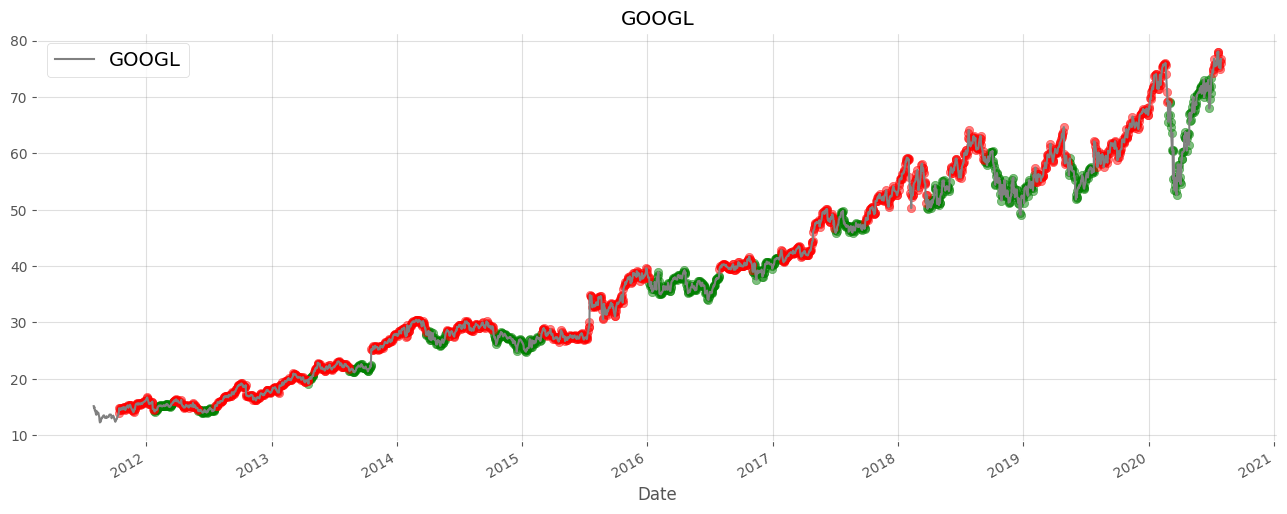

In [4]:
tickers = ['GOOGL']
ma_window = 42
threshold = 2

googl = (
    download_prices(
        tickers = tickers, 
        start = '2011-08-01', 
        end = '2020-07-31'
    )
)

googl = (
    compute_ma(
        df = googl,
        tickers = tickers,
        ma_window = ma_window
    )
)

googl = (
    compute_threshold(
        df = googl,
        tickers = tickers,
        ma_window = ma_window,
        sd_threshold = threshold
    )
)

googl = (
    compute_position(
        df = googl,
        tickers = tickers
    )
)

visualize(
    df = googl,
    ticker = 'GOOGL',
    var = 'GOOGL'
)

### <font color = blue> 👉 Question 2</font>. Let’s expand this strategy to two more securities, Apple (`AAPL`) and Amazon (`AMZN`) over the same period of August 2011 to July 2020. 

### When using the strategy above, which of those two securities has the greater Sharpe Ratio?

### Below are the lines of code that lead to an answer:

In [5]:
tickers = ['AAPL', 'AMZN']
ma_window = 42
threshold = 2

prices = (
    download_prices(
        tickers = tickers, 
        start = '2011-08-01', 
        end = '2020-07-31'
    )
)

prices = (
    compute_ma(
        df = prices,
        tickers = tickers,
        ma_window = ma_window
    )
)

prices = (
    compute_threshold(
        df = prices,
        tickers = tickers,
        ma_window = ma_window,
        sd_threshold = threshold
    )
)

prices = (
    compute_position(
        df = prices,
        tickers = tickers
    )
)

[*********************100%***********************]  2 of 2 completed


In [ ]:
returns = (
    np.log(
        prices
        [tickers]
    )
    .diff()
)

positions = (
    prices
    [[tic + '_trading_position' for tic in tickers]]
)

strategy = (
    returns 
    * 
    positions
    .to_numpy()
)

sharpe = (
    strategy.mean()
    /
    strategy.std()
    *
    np.sqrt(252)
)

sharpe

AAPL   -1.020638
AMZN   -0.959014
dtype: float64

### <font color = red> Answer 2 </font>

    The answer is AMZN .

### <font color = blue> 👉 Question 3</font>. Let’s suppose that you started from a `$200,000` capital base for each of the three securities.

### Disregarding commission, how much will you have in the end in your account for each of the securities as a result of the mean-reversion strategy-based trading?

### Below are the lines of code that lead to an answer:

In [7]:
tickers = ['GOOGL', 'AAPL', 'AMZN']
ma_window = 42
threshold = 2
capital = 200_000

prices = (
    download_prices(
        tickers = tickers, 
        start = '2011-08-01', 
        end = '2020-07-31'
    )
)

prices = (
    compute_ma(
        df = prices,
        tickers = tickers,
        ma_window = ma_window
    )
)

prices = (
    compute_threshold(
        df = prices,
        tickers = tickers,
        ma_window = ma_window,
        sd_threshold = threshold
    )
)

prices = (
    compute_position(
        df = prices,
        tickers = tickers
    )
)

returns = (
    np.log(
        prices
        [tickers]
    )
    .diff()
)

positions = (
    prices
    [[tic + '_trading_position' for tic in tickers]]
)

strategy = (
    returns 
    * 
    positions
    .to_numpy()
)

np.exp(strategy.cumsum()) * capital


[*********************100%***********************]  3 of 3 completed


,GOOGL,AAPL,AMZN
Date,,,
2011-08-01 00:00:00+00:00,NaN,NaN,NaN
2011-08-02 00:00:00+00:00,200000.000000,200000.000000,200000.000000
2011-08-03 00:00:00+00:00,200000.000000,200000.000000,200000.000000
2011-08-04 00:00:00+00:00,200000.000000,200000.000000,200000.000000
2011-08-05 00:00:00+00:00,200000.000000,200000.000000,200000.000000
...,...,...,...
2020-07-24 00:00:00+00:00,16563.332835,14556.310323,58336.433343
2020-07-27 00:00:00+00:00,16179.864750,14335.717340,57527.052564
2020-07-28 00:00:00+00:00,16450.097208,14597.936876,58513.347987


### <font color = red> Answer 3 </font>

    GOOGL : ____________ 
    
    AAPL  : ____________ 
     
    AMZN  : ____________ 
    

### <font color = blue> 👉 Question 4</font>. What are the compound annual growth rates of each of the securities, based on the current mean-reversion strategy-based trading? 

### Below are the lines of code that lead to an answer:

In [ ]:
np.exp(strategy.cumsum()).iloc[-1:,:] ** (252 / len(strategy)) - 1 

,GOOGL,AAPL,AMZN
Date,,,
2020-07-30 00:00:00+00:00,-0.245253,-0.254058,-0.130018


### <font color = red> Answer 4 </font>

    GOOGL : ____________ 
    
    AAPL  : ____________ 
     
    AMZN  : ____________ 

## 👇 Questions 5 and 7 ask you to predict the future market direction. Let's focus on analyzing `GE`. `These questions are designed to help deepen your understanding of the key points covered in the Lesson 5 lecture notes`. While answering, please make sure to revisit and refer to the `Lecture 5 notebook`.

###  <font color = blue> 👉 Question 5. </font> First, predict tomorrow's log returns using today's returns, yesterday's returns, and the day before yesterday's returns — a total of three lags. 

### Next, predict tomorrow's log returns using a lag of 10 days. 

### Finally, predict tomorrow's log returns using a lag of 22 days. 

### You can achieve this using the least squares function in the numpy library's linear algebra module. 

### Then, plot the gross performance of the base instrument and the three strategies that can be constructed based on these three lagged variables over time. 

### This analysis is conducted in-sample and does not consider transaction costs. </font>

### Below are the lines of code that lead to an answer:

In [9]:
def compute_lag(
    df: pd.DataFrame,
    tickers: list[str],
    lag: int,
) -> pd.DataFrame:
    for ticker in tickers:
        
        df[f'{ticker}_lag_{lag}_ret'] = (
            df
            [ticker]
            .shift(lag)
        )
        
    return df

In [10]:
tickers = ['GE']

GE = (
    download_prices(
        tickers = tickers,
        start = '2011-08-01', 
        end = '2020-07-31'
    )
)

GE = (
    np.log(
        GE
    )
    .diff()
)

lags = [1, 2, 10, 22]

for lag in lags:
    GE = (
        compute_lag(
            df = GE,
            tickers = tickers,
            lag = lag
        )
    )

[*********************100%***********************]  1 of 1 completed


In [11]:
def prediction(
    df: pd.DataFrame,
    x_columns: list,
    y_columns: str,
    pred_type: str
):
    x = df[x_columns].dropna()
    y = df[[y_columns]].iloc[-len(x) : , : ]
    
    
    REGRESSION = (
        np.linalg.lstsq (
            x,
            np.sign(y),
            rcond = None
        )
        [0]
    )

    df[pred_type] = (
        np.sign(
            np.dot(
                df[x_columns],
                REGRESSION
            )
        )
    )
    
    return df

In [12]:
GE = prediction(
    df = GE,
    x_columns = GE.columns[1 : 3],
    y_columns = 'GE',
    pred_type = 'prediction_past_2_days'
)

GE = prediction(
    df = GE,
    x_columns = ['GE_lag_10_ret'],
    y_columns = 'GE',
    pred_type = 'prediction_past_10_days'
)

GE = prediction(
    df = GE,
    x_columns = ['GE_lag_22_ret'],
    y_columns = 'GE',
    pred_type = 'prediction_past_22_days'
)

### <font color = red> Answer 5 </font>

    The answer is shown in the below plot.

<Axes: xlabel='Date'>

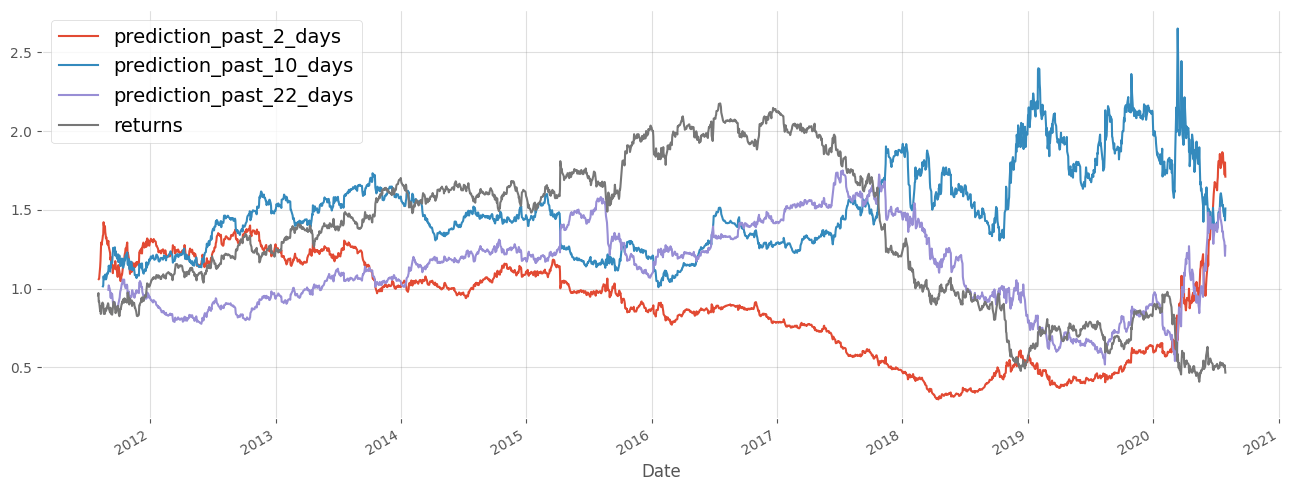

In [13]:
GE_strategy = (
    GE[['GE']]
    .to_numpy()
    * 
    GE[[col for col in GE.columns if 'prediction' in col]]   
)

GE_strategy['returns'] = GE[['GE']]

GE_strategy_cumulative = (
    np.exp(
        GE_strategy
        .cumsum()
    )
)

GE_strategy_cumulative.plot(figsize = (16,6))

###  <font color = blue> 👉 Question 6. </font> Now, let's define performance metrics for accuracy.

### In Chapter 4 of the Lesson 5 lecture note, we calculated accuracy with the operational knowledge that, while it's theoretically possible for both returns and predictions to be positive, negative, or zero, only returns contained zero values. Predictions, on the other hand, did not include zeros; as a result, we considered them invalid predictions rather than irrelevant.

### Below, you will find two prototype functions (namely, `calculate_accuracy_A` and `calculate_accuracy_B`) that you can adapt for accuracy calculations. Please evaluate both functions and decide which one you prefer to use as a prototype for your work. Subsequently, explain why you favor the specific function for assessing accuracy.

### Then, using the chosen prototype of function, revise it and execute to assess the accuracy of the predictions obtained from the above lags approaches.

In [14]:
def calculate_accuracy_A(returns, predictions):

    # Ensure returns and predictions have the same length
    assert len(returns) == len(predictions), "Returns and predictions must have the same length."

    # Initialize variables for valid and total predictions
    valid_predictions = 0
    total_predictions = len(returns)

    # Loop through each data point
    for i in range(total_predictions):
        # Check if the return is zero (valid) and the prediction is not zero (invalid)
        if returns[i] == 0 and predictions[i] != 0:
            valid_predictions += 1
        # Check if the return is not zero and the prediction matches closely (within a tolerance, if needed)
        elif returns[i] != 0 and abs(returns[i] - predictions[i]) < tolerance:
            valid_predictions += 1

    # Calculate accuracy
    accuracy_A = valid_predictions / total_predictions

    return accuracy_A

In [15]:
def calculate_accuracy_B(returns_series, predictions_series):
    
    # Correct predictions
    correct_positive = (returns_series > 0) & (predictions_series > 0)
    correct_negative = (returns_series < 0) & (predictions_series < 0)
    correct_zero = (returns_series == 0) & (predictions_series == 0)

    total_correct = correct_positive.sum() + correct_negative.sum() + correct_zero.sum()

    # Incorrect predictions
    incorrect_positive_return = (returns_series > 0) & (predictions_series <= 0)
    incorrect_negative_return = (returns_series < 0) & (predictions_series >= 0)
    incorrect_zero_return = (returns_series == 0) & (predictions_series != 0)

    total_incorrect =\
    (
        incorrect_positive_return.sum()
        + incorrect_negative_return.sum()
        + incorrect_zero_return.sum()
    )

    # Calculate Hit
    accuracy_B = total_correct / (total_correct + total_incorrect)
    
    return accuracy_B

### Below are the lines of code that lead to an answer:

In [16]:
prediction_columns = ['prediction_past_2_days', 'prediction_past_10_days', 'prediction_past_22_days']

for prediction_col in prediction_columns:
    accuracy = calculate_accuracy_B(GE['GE'], GE[prediction_col])
    correct = int(accuracy * len(GE))
    wrong = len(GE) - correct
    print(f'The prediction is {correct} times correct and {wrong} wrong. The accuracy is {round(accuracy * 100, 2)}% with a {prediction_col} lag')

The prediction is 1137 times correct and 1128 wrong. The accuracy is 50.22% with a prediction_past_2_days lag
The prediction is 1103 times correct and 1162 wrong. The accuracy is 48.71% with a prediction_past_10_days lag
The prediction is 1101 times correct and 1164 wrong. The accuracy is 48.62% with a prediction_past_22_days lag


### <font color = red> Answer 6 </font>
    The prediction is _____ times correct and _____ wrong. The accuracy is ______ % with a 3-day lag.
    
    The prediction is _____ times correct and _____ wrong. The accuracy is ______ % with a 10-day lag.
    
    The prediction is _____ times correct and _____ wrong. The accuracy is ______ % with a 22-day lag.
    

###  <font color = blue> 👉 Question 7. </font> Please calculate the Sharpe Ratio of the strategies for  `GE`.

### Below are the lines of code that lead to an answer:

In [17]:
(
    GE_strategy[prediction_columns].mean()
    /
    GE_strategy[prediction_columns].std()
    *
    np.sqrt(252)
)

prediction_past_2_days     0.187860
prediction_past_10_days    0.146224
prediction_past_22_days    0.085814
dtype: float64

### <font color = red> Answer 7 </font>

    The strategy for GE with a 3-day lag leads to a Sharpe ratio of __________ .
    
    The strategy for GE with a 3-day lag leads to a Sharpe ratio of __________ .
        
    The strategy for GE with a 3-day lag leads to a Sharpe ratio of __________ .

## 👇 Questions 8 to 10 ask you to build, execute, and backtest a momentum strategy.

###  <font color = blue> 👉 Question 8. </font> Our securities of interest are Goldman Sachs (`GS`) and JP Morgan Chase (`JPM`) stock. The time period for analysis is from November 2013 to October 2021.

### Here’s our use of the momentum indicator, reflecting the moving averages of stock prices for trend following.

### The two moving windows are 24 days and 58 days.

### Calculate and visualize the maximum drawdowns and the longest drawdown periods for `GS` and `JPM`.

### Below are the lines of code that lead to an answer:

In [18]:
tickers = ['GS', 'JPM']
ma_windows = [24, 58]

GS_JP = (
    download_prices(
        tickers = tickers,
        start = '2011-08-01', 
        end = '2020-07-31'
    )
)

for ma_window in ma_windows:
    GS_JP = compute_ma(
        df = GS_JP,
        tickers = tickers,
        ma_window = ma_window
    )
    
def compute_mom_position(
    df: pd.DataFrame,
    tickers: list[str],
    short_ma: int,
    long_ma: int
) -> pd.DataFrame:
    for ticker in tickers:
        df[f'{ticker}_trading_position'] = (
            np.where(
                df[f'{ticker}{short_ma}d_MA'] > df[f'{ticker}{long_ma}d_MA'],
                1,
                -1
            )
        )
        
    return df

GS_JP = (
    compute_mom_position(
        df = GS_JP,
        tickers = tickers,
        short_ma = ma_windows[0],
        long_ma = ma_windows[1]
    )
)

[*********************100%***********************]  2 of 2 completed


In [19]:
GS_JP_returns = (
    np.log(
        GS_JP
        [tickers]
    )
    .diff()
    .fillna(0)
)

positions = (
    GS_JP
    [[tic + '_trading_position' for tic in tickers]]
)

GS_JP_strategy = (
    GS_JP_returns 
    * 
    positions
    .to_numpy()
)

GS_JP_stratgy_gross = (
    GS_JP_strategy
    .cumsum()
    .cummax()
    .rename(
        columns = {
            tic : f'{tic}_max_gross_performance'
            for tic in tickers
        }
    )
)

GS_JP_strategy = (
    pd.concat(
        [
            np.exp(
                GS_JP_strategy.cumsum()
            ),
            np.exp(
                GS_JP_stratgy_gross
            )
        ],
        axis = 1
    )
)


### <font color = red> Answer 8 (`visualization component`) is presented in the cell below: </font>

<Axes: xlabel='Date'>

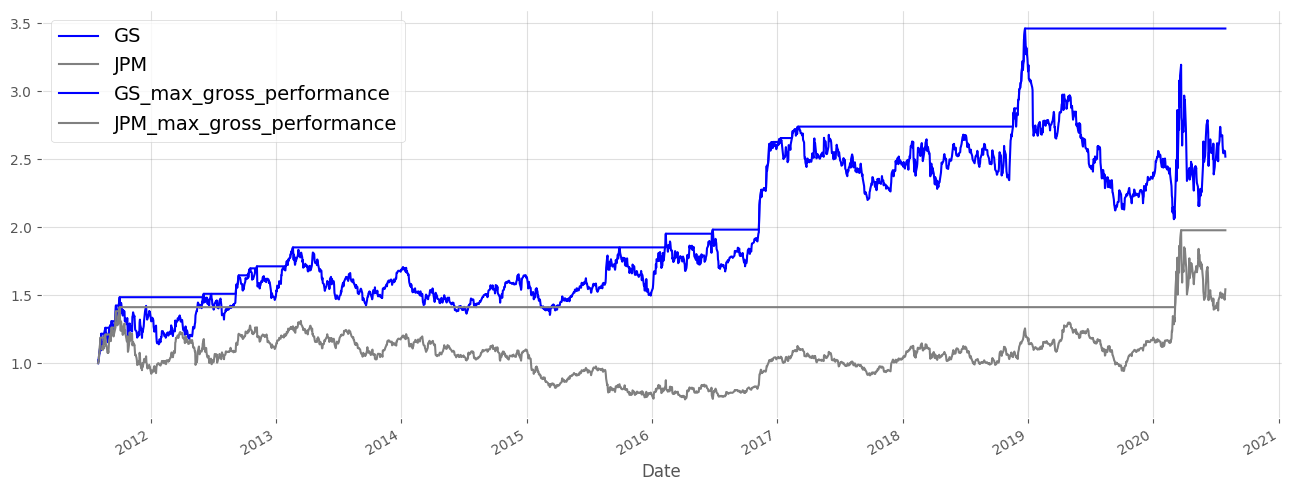

In [20]:
GS_JP_strategy.plot(
    figsize = (16, 6),
    color = ['blue', 'grey', 'blue', 'grey']
)

In [21]:
def compute_drawdown(
    df: pd.DataFrame,
    tickers: list[str]
):  
    for ticker in tickers:
        filter_df = df[[col for col in df.columns if ticker in col]]
        drawdown = 1 - (filter_df[ticker] / filter_df[f'{ticker}_max_gross_performance'])

        periods = (
            np.diff(
                np.append(
                    drawdown[drawdown == 0].index,
                    drawdown.index[-1 : ]
                )
            )
        )

        max_period = (
            periods.max()
        /
        np.timedelta64(1, 'D') 
        )

        print(drawdown.max(), max_period)


In [ ]:
compute_drawdown(
    df = GS_JP_strategy,
    tickers = tickers
)

0.40528910102490945 952.0
0.4808670647893918 3077.0


### <font color = red> Answer 8 </font>
    
    As to GS,
    
    The maximum drawdown is about ____________ percentage points.
    The longest drawdown period lasts for _____________ days.
    
    As to JPM,
    
    The maximum drawdown is about ____________ percentage points.
    The longest drawdown period lasts for _____________ days.
    

###  <font color = blue> 👉 Question 9. </font>  If you had started with a capital of $300,000 for each of the three securities, how much would be left in your account after trading according to your above strategies for `GS` and `JPM`?

### Below are the lines of code that lead to an answer:

In [23]:
(
    GS_JP_strategy
    [tickers] 
    * 
    300_000
).iloc[-1]

GS     755643.969149
JPM    462847.888865
Name: 2020-07-30 00:00:00+00:00, dtype: float64

### <font color = red> Answer 9 </font>

    The answer is ____________________________ .

###  <font color = blue> 👉 Question 10. </font> Using the current momentum strategy, how many trading opportunities were there for GS and JPM?

### Below are the lines of code that lead to an answer:

In [ ]:
(
    GS_JP
    [[col for col in GS_JP.columns if 'trading_position' in col]]
    .diff()
    .value_counts()
    .to_frame()
    .reset_index()
    
)

,GS_trading_position,JPM_trading_position,0
0,0.0,0.0,2176
1,0.0,-2.0,22
2,-2.0,0.0,21
3,0.0,2.0,21
4,2.0,0.0,21
5,2.0,2.0,2
6,-2.0,-2.0,1


### <font color = red> Answer 10 </font>

    The answer is ____________________________ .

> 💯 “Thank you for putting your efforts into the individual assessment questions” 😊